In [0]:
import torch
import gym
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import random
from IPython.display import clear_output
from multiprocessing.pool import ThreadPool
import numpy as np

In [0]:
class ActorNet(nn.Module):
    def __init__(self,input_dim_act,output_dim):
        super(ActorNet,self).__init__()
        self.fc1 = nn.Linear(input_dim_act,128)
        self.elu1 = nn.Tanh()
        self.fc2 = nn.Linear(128,64)
        self.elu2 = nn.Tanh()
        self.fc3 = nn.Linear(64,64)
        self.elu3 = nn.Tanh()
        self.fc4 = nn.Linear(64,output_dim)
        
    def forward(self,obj,action=False,max_act=False):
        x = torch.FloatTensor(obj)
        x = self.elu1(self.fc1(x))
        x = self.elu2(self.fc2(x))
        x = self.elu3(self.fc3(x))
        logits = self.fc4(x)
        m = Categorical(logits=logits)
        act = m.sample()
        log_p = m.log_prob(act)
        if action:
            return m.log_prob(torch.LongTensor(action))
        else:
            if max_act:
                return torch.argmax(logits).item()
            else:
                return m,act.item(),log_p

In [0]:
n_stacks = 5
make = 'Breakout-ram-v0'

In [0]:
env = gym.make(make)

In [0]:
input_dim = env.observation_space.shape[0]
input_dim_act = n_stacks*env.observation_space.shape[0]
input_dim_v = env.observation_space.shape[0]

In [0]:
output_dim = env.action_space.n

In [0]:
act_net = ActorNet(input_dim_act,output_dim)

In [0]:
class CriticNet(nn.Module):
    def __init__(self,input_dim_v):
        super(CriticNet,self).__init__()
        self.fc1 = nn.Linear(input_dim_v,128)
        self.elu1 = nn.Tanh()
        self.fc2 = nn.Linear(128,64)
        self.elu2 = nn.Tanh()
        self.fc3 = nn.Linear(64,64)
        self.elu3 = nn.Tanh()
        self.fc4 = nn.Linear(64,1)
        
    def forward(self,obj):
        x = torch.FloatTensor(obj)
        x = self.elu1(self.fc1(x))
        x = self.elu2(self.fc2(x))
        x = self.elu3(self.fc3(x))
        v = self.fc4(x)
        return v

In [0]:
crit_net = CriticNet(input_dim_v)

In [0]:
gamma = 0.99
lamda = 0.95
clip_ratio = 0.2
lr_pi = 1e-4
lr_v = 1e-3
target_kl = 0.01
train_pi_iter = 5
train_v_iter = 5
traj_n = 10
iters = 1000

In [0]:
optim_actor = optim.Adam(params=act_net.parameters(),lr=lr_pi)
optim_critic = optim.Adam(params=crit_net.parameters(),lr=lr_v)

In [0]:
def disc_cuml_rew_calc(rews,gamma=gamma):
    return list(scipy.signal.lfilter([1], [1, float(-gamma)], rews[::-1], axis=0)[::-1])

In [0]:
def traject(t):
    traj = []
    rews = []
    env = gym.make(make)
    obj = env.reset()
    done = False
    stacked_states = np.zeros((n_stacks,1,input_dim))
    while not done:
        stacked_states = np.concatenate((stacked_states[-1].reshape((1,1,input_dim)), stacked_states[0:-1]))
        stacked_states[0] = obj.copy()
        v = crit_net.forward(obj)
        m,act,log_p = act_net.forward(stacked_states.reshape(1,n_stacks*input_dim))
        next_obj,reward,done,_ = env.step(act)
        traj.append([act,obj,next_obj,reward,done,log_p,v,stacked_states.reshape(1,n_stacks*input_dim)])
        rews.append(reward)
        obj = next_obj
    rews_disc_cuml_scaled = disc_cuml_rew_calc(rews)
    act,obj,_,rews,_,old_policy,v,stacked_states = zip(*traj)
    adv = [rews[i] + gamma*v[i+1] - v[i] for i in range(len(rews)-1)] + [0 - v[-1]]
    adv = torch.FloatTensor(adv)
    adv = disc_cuml_rew_calc(adv.numpy(),gamma*lamda)
    adv = torch.FloatTensor(adv)
    adv = (adv - adv.mean())/adv.std()
    traj = [i + [j,k] for i,j,k in zip(traj,rews_disc_cuml_scaled,adv)]
    return traj,rews

400


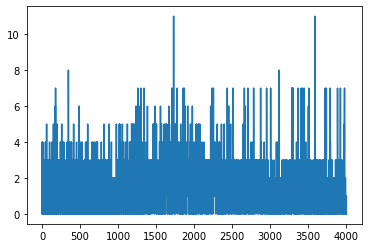

401
402
403
404
405
406
407


In [0]:
rewards = []
for k in range(iters):
    print(k)
    process = ThreadPool(processes=1)
    out = process.map(traject,range(10))
    process.close()
    process.join()
    trajectories,rewards_t = list(zip(*out))
    rewards.extend(rewards_t)
    trajectories = reduce(lambda a,b: a+b,trajectories)
    act,obj,_,rews,_,old_policy,v,stacked_states,rews_disc_cuml,adv = zip(*trajectories)
    adv = torch.FloatTensor(adv)
    old_policy = torch.FloatTensor(old_policy)

    for t in range(train_pi_iter):
        new_policy = act_net.forward(stacked_states,action=act)
        ratio = torch.exp(new_policy-old_policy)
        clip_adv = torch.clamp(ratio, 1-clip_ratio, 1+clip_ratio) * adv
        loss_pi = -(torch.min(ratio * adv, clip_adv)).mean()
        optim_actor.zero_grad()
        loss_pi.backward()
        optim_actor.step()
        if (new_policy - old_policy).mean().item() > 1.5 * target_kl:
            print('early_stopping')
            break

    for t in range(train_v_iter):
        loss_v = ((crit_net.forward(obj) - torch.FloatTensor(rews_disc_cuml)) ** 2).mean()
        optim_critic.zero_grad()
        loss_v.backward()
        optim_critic.step()
        
        
    if k % 10 == 0:
        clear_output(wait=True)
        print(k)
        episode_returns = [sum(i) for i in rewards]
        plt.plot(episode_returns)
        plt.show()

In [0]:
episode_returns = [sum(i) for i in rewards]

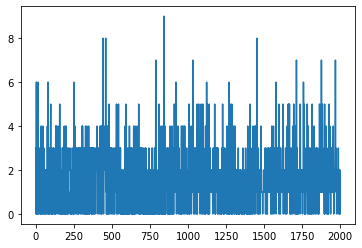

In [16]:
plt.plot(episode_returns)

In [0]:
import time

In [0]:
done = False
obj = env.reset()
rw = 0
while not done:
#     print('**********************************')
    act = k.forward(obj,max_act=True)
    time.sleep(0.02)
#     print(m.logits)
#     print(m.logits.argmax())
#     print(act)
    obj,reward,done,_ = env.step(act)
    rw += reward
    env.render()
env.close()
print(rw)

270.0


In [0]:
env.close()

In [0]:
act

0

In [0]:
m.logits

tensor([-1.6989, -1.7558, -2.4567, -0.5823], grad_fn=<SubBackward0>)

In [17]:
k = torch.load('ppo_multitraj_state_stack_breakout')

FileNotFoundError: ignored

In [18]:
torch.save(act_net,'ppo_multitraj_state_stack_breakout')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ActorNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
